# Image classifier for the SVHN dataset


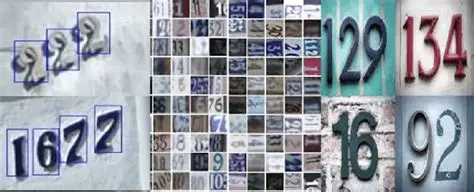

This notebook shows a comparison of MLP vs CNN with the SVHN dataset, comparing them through accuracy, showing that CNNs are superior for image classification, even with fewer parameters, due to their ability to create kernels that capture the relevant relationship by neighborhood. Note that there was no preprocessing of the images, they were simply converted to grayscale and normalized to [0,1].

### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish.

In [1]:
# Standard library
import os

# Third-party scientific stack
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

# Deep learning
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, metrics
from tensorflow.keras.models import load_model  

2025-11-29 04:27:26.973103: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-29 04:27:26.987006: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764412047.000570   79769 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764412047.004330   79769 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764412047.015280   79769 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
tf.__version__

'2.19.1'

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [3]:
# # Download the SVHN dataset

# # Create a directory to store the data
# !mkdir -p svhn_data

# # Download the training and test datasets
# !wget -O svhn_data/train_32x32.mat http://ufldl.stanford.edu/housenumbers/train_32x32.mat
# !wget -O svhn_data/test_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

# 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [4]:

def load_svhn(train_mat_path, test_mat_path):
    """
    Load SVHN .mat files and return raw dicts.
    """
    train = loadmat(train_mat_path)
    test = loadmat(test_mat_path)
    return train, test


def extract_svhn_images_labels(svhn_dict):
    """
    Extract (images, labels) from an SVHN .mat dictionary.

    - Input images shape in SVHN: (H, W, C, N)
    - Output images shape: (N, H, W, C)
    - Labels: convert shape (N, 1) -> (N,)
             and map label 10 -> 0 (SVHN convention for digit '0').
    """
    X = svhn_dict["X"]      # (32, 32, 3, N)
    y = svhn_dict["y"]      # (N, 1) with digits 1..10, where 10 is '0'

    # Move N to first dimension: (N, 32, 32, 3)
    X = np.transpose(X, (3, 0, 1, 2))

    # Squeeze labels to 1D: (N,)
    y = y.squeeze()

    # Map label 10 -> 0 (digit '0')
    y = np.where(y == 10, 0, y)

    return X, y


def show_random_samples(images, labels, num_samples=10, title="Random samples", seed=None, cmap=None):
    """
    Show a grid of random samples from (images, labels).

    images: ndarray (N, H, W, C)
    labels: ndarray (N,)
    num_samples: how many images to display
    cmap: use 'gray' for grayscale, None for RGB
    """
    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    N = images.shape[0]
    num_samples = min(num_samples, N)

    idx = rng.choice(N, size=num_samples, replace=False)
    imgs = images[idx]
    lbls = labels[idx]

    # Determine grid size
    cols = 5
    rows = 2

    plt.figure(figsize=(2 * cols, 2 * rows))
    plt.suptitle(title, fontsize=14)

    for i in range(num_samples):
        ax = plt.subplot(rows, cols, i + 1)
        img = imgs[i]

        # If grayscale stored as (H, W, 1), squeeze last channel
        if img.shape[-1] == 1:
            ax.imshow(img.squeeze(-1), cmap=cmap or "gray")
        else:
            ax.imshow(img, cmap=cmap)

        ax.set_title(f"Label: {lbls[i]}", fontsize=8)
        ax.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def rgb_to_grayscale_keep_channel(images):
    """
    Convert RGB images to grayscale by averaging channels.
    Keep channel dimension: (N, H, W, 3) -> (N, H, W, 1).
    """
    # Mean over channel axis (-1) and keepdims=True to retain (H, W, 1)
    gray = np.mean(images, axis=-1, keepdims=True)
    return gray


def preprocess_svhn_to_grayscale(train_mat_path="svhn_data/train_32x32.mat",
                                 test_mat_path="svhn_data/test_32x32.mat"):
    """
    Complete pipeline for Step 1 of your task:

    1) Load SVHN .mat files
    2) Extract RGB train/test images and labels
    3) Convert RGB images to grayscale (channel dimension kept as 1)
    4) Return all arrays

    Returns
    -------
    x_train_rgb : (N_train, 32, 32, 3)
    y_train     : (N_train,)
    x_test_rgb  : (N_test, 32, 32, 3)
    y_test      : (N_test,)
    x_train_gray: (N_train, 32, 32, 1)
    x_test_gray : (N_test, 32, 32, 1)
    """
    train_dict, test_dict = load_svhn(train_mat_path, test_mat_path)

    x_train_rgb, y_train = extract_svhn_images_labels(train_dict)
    x_test_rgb, y_test = extract_svhn_images_labels(test_dict)

    x_train_gray = rgb_to_grayscale_keep_channel(x_train_rgb)
    x_test_gray = rgb_to_grayscale_keep_channel(x_test_rgb)

    return x_train_rgb, y_train, x_test_rgb, y_test, x_train_gray, x_test_gray


def visualize_svhn_rgb_and_gray(x_train_rgb, y_train, x_train_gray, num_samples=10, seed=None):
    """
    Convenience function:
    - Show random RGB samples with labels
    - Show random grayscale samples with labels
    """
    show_random_samples(
        x_train_rgb,
        y_train,
        num_samples=num_samples,
        title="SVHN RGB samples",
        seed=seed,
        cmap=None,
    )

    show_random_samples(
        x_train_gray,
        y_train,
        num_samples=num_samples,
        title="SVHN grayscale samples",
        seed=seed,
        cmap="gray",
    )


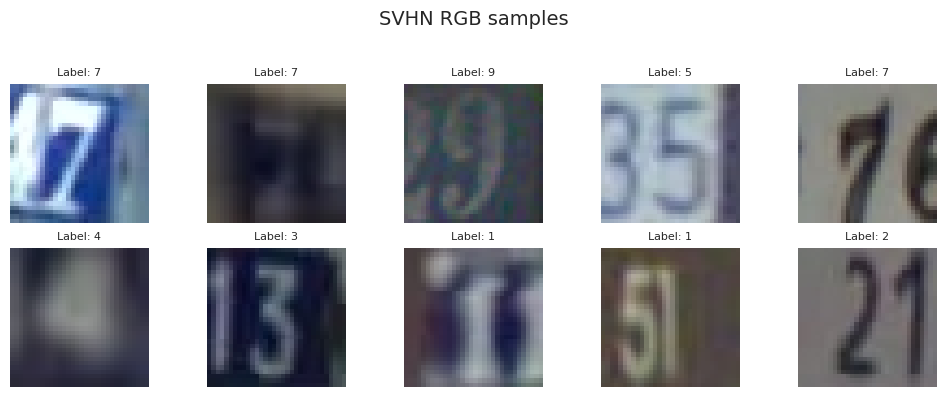

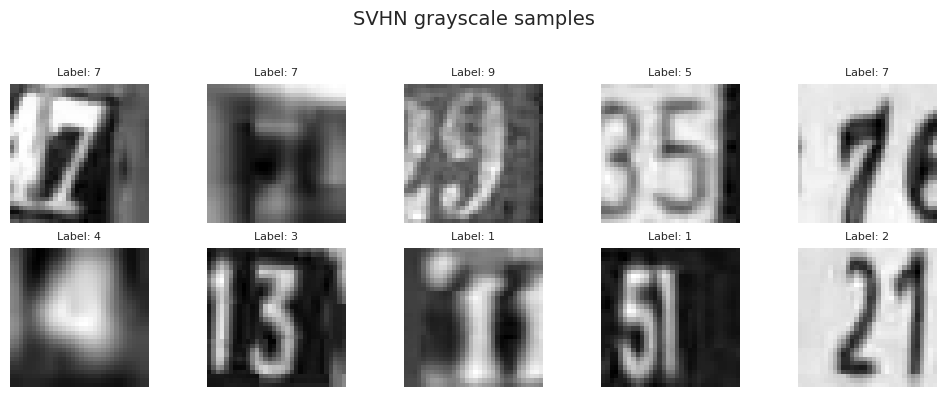

In [5]:
# 1) Preprocess
x_train_rgb, y_train, x_test_rgb, y_test, x_train_gray, x_test_gray = preprocess_svhn_to_grayscale(
    train_mat_path="svhn_data/train_32x32.mat",
    test_mat_path="svhn_data/test_32x32.mat",
)

# 2) Visualize at least 10 random RGB + grayscale images
visualize_svhn_rgb_and_gray(
    x_train_rgb,
    y_train,
    x_train_gray,
    num_samples=10,
    seed=863,
)


# 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output.
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [6]:
def prepare_mlp_data_from_svhn_gray(
    x_train_gray,
    y_train,
    x_test_gray,
    y_test,
    val_size=0.2,
    random_state=863,
):
    """
    Split SVHN grayscale data into train/validation, and normalize to [0, 1].

    Inputs
    ------
    x_train_gray : (N_train, 32, 32, 1), uint8 or float
    y_train      : (N_train,), int labels 0..9
    x_test_gray  : (N_test, 32, 32, 1)
    y_test       : (N_test,)

    Returns
    -------
    x_tr, y_tr, x_val, y_val, x_te, y_te
      all images float32 in [0,1]
    """
    # Train/validation split, stratified by labels
    x_tr, x_val, y_tr, y_val = train_test_split(
        x_train_gray,
        y_train,
        test_size=val_size,
        random_state=random_state,
        stratify=y_train,
    )

    # Normalize to [0,1]
    x_tr = x_tr.astype("float32") / 255.0
    x_val = x_val.astype("float32") / 255.0
    x_te = x_test_gray.astype("float32") / 255.0

    return x_tr, y_tr, x_val, y_val, x_te, y_test


In [7]:
def build_mlp_model(
    input_shape=(32, 32, 1),
    num_classes=10,
    hidden_units=(512, 256, 128),
    dropout_rate=0.5,
):
    """
    Build an MLP (Flatten + Dense only) with a 10-way softmax output.
    """
    model = models.Sequential(name="SVHN_MLP")

    # Flatten images (32x32x1 -> 1024)
    model.add(layers.Flatten(input_shape=input_shape, name="flatten_input"))

    # Hidden Dense layers
    for i, units in enumerate(hidden_units, start=1):
        model.add(layers.Dense(units, activation="relu", name=f"dense_{i}"))
        # model.add(layers.BatchNormalization(name=f"bn_{i}"))
        # model.add(layers.Dropout(dropout_rate, name=f"dropout_{i}"))

    # Output layer: 10-way softmax
    model.add(layers.Dense(num_classes, activation="softmax", name="output"))

    return model


def compile_mlp_model(model, learning_rate=1e-3):
    """
    Compile the MLP with sparse categorical crossentropy and accuracy metric.
    """
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=[metrics.SparseCategoricalAccuracy(name="accuracy")],
    )
    return model


In [8]:
def get_mlp_callbacks(
    base_dir="svhn_mlp_checkpoints",
    monitor="val_accuracy",
    patience=5,
):
    """
    Create callbacks for:
    - ModelCheckpoint: saves best model by val_accuracy
    - EarlyStopping: stops when val_accuracy stops improving
    - ReduceLROnPlateau: reduce LR when val_accuracy plateaus
    """
    os.makedirs(base_dir, exist_ok=True)
    checkpoint_path = os.path.join(base_dir, "best_mlp_checkpoint.keras")

    checkpoint_cb = callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor=monitor,
        mode="max",
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    )

    early_stopping_cb = callbacks.EarlyStopping(
        monitor=monitor,
        mode="max",
        patience=patience,
        restore_best_weights=True,
        verbose=1,
    )

    reduce_lr_cb = callbacks.ReduceLROnPlateau(
        monitor=monitor,
        mode="max",
        factor=0.5,
        patience=max(1, patience // 2),
        min_lr=1e-5,
        verbose=1,
    )

    return [checkpoint_cb, early_stopping_cb, reduce_lr_cb]


In [9]:
def train_mlp_model(
    model,
    x_tr,
    y_tr,
    x_val,
    y_val,
    epochs=30,
    batch_size=128,
    callbacks_list=None,
    verbose=2,
):
    """
    Train the MLP on training data with validation monitoring.
    """
    history = model.fit(
        x_tr,
        y_tr,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        callbacks=callbacks_list or [],
        verbose=verbose,
    )
    return history


In [10]:
def plot_mlp_learning_curves(history):
    """
    Plot loss vs epoch and accuracy vs epoch for training and validation.
    """
    hist = history.history
    epochs = range(1, len(hist["loss"]) + 1)

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist["loss"], label="train loss")
    plt.plot(epochs, hist["val_loss"], label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch")
    plt.grid(True)
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist["accuracy"], label="train accuracy")
    plt.plot(epochs, hist["val_accuracy"], label="val accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epoch")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


In [11]:
def evaluate_mlp_on_test(model, x_test, y_test):
    """
    Compute and print loss and accuracy on the test set.
    """
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test loss:     {test_loss:.4f}")
    print(f"Test accuracy: {test_acc:.4f}")
    return test_loss, test_acc


/home/nvidia/miniforge3/envs/rapids-25.10-cuda12/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1764412053.032864   79769 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "SVHN_MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_input (Flatten)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 690,314 (2.63 MB)

 Trainable params: 690,314 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


I0000 00:00:1764412054.935078   79905 service.cc:152] XLA service 0x7ebb0800a730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764412054.935161   79905 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-11-29 04:27:34.958792: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764412055.118181   79905 cuda_dnn.cc:529] Loaded cuDNN version 91600
2025-11-29 04:27:35.737040: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_172', 8 bytes spill stores, 8 bytes spill loads

2025-11-29 04:27:35.783440: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_d


Epoch 1: val_accuracy improved from None to 0.48430, saving model to svhn_mlp_checkpoints/best_mlp_checkpoint.keras
458/458 - 19s - 42ms/step - accuracy: 0.2814 - loss: 2.0143 - val_accuracy: 0.4843 - val_loss: 1.5000 - learning_rate: 0.0010
Epoch 2/30

Epoch 2: val_accuracy improved from 0.48430 to 0.58722, saving model to svhn_mlp_checkpoints/best_mlp_checkpoint.keras
458/458 - 1s - 3ms/step - accuracy: 0.5576 - loss: 1.3439 - val_accuracy: 0.5872 - val_loss: 1.2576 - learning_rate: 0.0010
Epoch 3/30

Epoch 3: val_accuracy improved from 0.58722 to 0.66557, saving model to svhn_mlp_checkpoints/best_mlp_checkpoint.keras
458/458 - 1s - 3ms/step - accuracy: 0.6358 - loss: 1.1486 - val_accuracy: 0.6656 - val_loss: 1.0535 - learning_rate: 0.0010
Epoch 4/30

Epoch 4: val_accuracy improved from 0.66557 to 0.70298, saving model to svhn_mlp_checkpoints/best_mlp_checkpoint.keras
458/458 - 2s - 3ms/step - accuracy: 0.6740 - loss: 1.0402 - val_accuracy: 0.7030 - val_loss: 0.9559 - learning_rate:

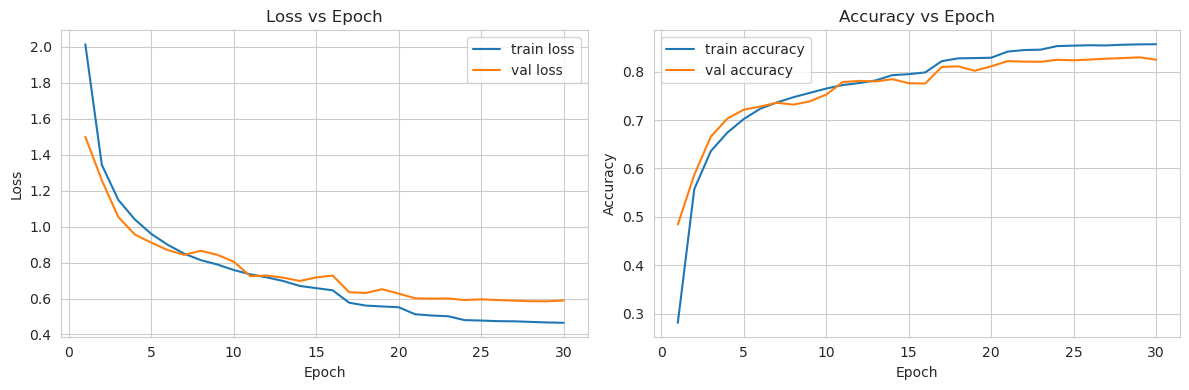

2025-11-29 04:28:49.619056: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_40', 484 bytes spill stores, 484 bytes spill loads

2025-11-29 04:28:49.758380: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_40_0', 44 bytes spill stores, 44 bytes spill loads

2025-11-29 04:28:49.874323: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_54', 4 bytes spill stores, 4 bytes spill loads

2025-11-29 04:28:52.949517: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_40', 52 bytes spill stores, 52 bytes spill loads



Test loss:     0.7057
Test accuracy: 0.8003


In [12]:
# 1) Prepare data (train/val split + normalization)
x_tr, y_tr, x_val, y_val, x_te, y_te = prepare_mlp_data_from_svhn_gray(
    x_train_gray,
    y_train,
    x_test_gray,
    y_test,
    val_size=0.2,
    random_state=863,
)

# 2) Build, compile, and show model summary
mlp_model = build_mlp_model(input_shape=x_tr.shape[1:], num_classes=10, hidden_units=(512, 256, 128))
compile_mlp_model(mlp_model, learning_rate=1e-3)
mlp_model.summary()

# 3) Callbacks
mlp_callbacks = get_mlp_callbacks(
    base_dir="svhn_mlp_checkpoints",
    monitor="val_accuracy",
    patience=5,
)

# 4) Train (max 30 epochs as suggested)
history_mlp = train_mlp_model(
    mlp_model,
    x_tr,
    y_tr,
    x_val,
    y_val,
    epochs=30,
    batch_size=128,
    callbacks_list=mlp_callbacks,
)

# 5) Plot learning curves
plot_mlp_learning_curves(history_mlp)

# 6) Evaluate on test set
test_loss, test_acc = evaluate_mlp_on_test(mlp_model, x_te, y_te)


# 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output.
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [13]:
def build_cnn_model(
    input_shape=(32, 32, 1),
    num_classes=10,
    conv_filters=(16, 32, 64),
    dense_units=64,
    dropout_rate=0.5,
):
    """
    Build a compact CNN for SVHN grayscale classification.

    Uses:
      - Conv2D + BatchNorm + MaxPool2D blocks
      - Flatten
      - Dense + Dropout
      - Final Dense(num_classes) with softmax

    Designed to have fewer trainable parameters than the MLP model
    from the previous step (for typical choices).
    """
    model = models.Sequential(name="SVHN_CNN")

    # ----- Convolutional block 1 -----
    model.add(layers.Conv2D(
        filters=conv_filters[0],
        kernel_size=(3, 3),
        padding="same",
        activation="relu",
        input_shape=input_shape,
        name="conv1",
    ))
    model.add(layers.BatchNormalization(name="bn1"))
    model.add(layers.MaxPool2D(pool_size=(2, 2), name="pool1"))

    # ----- Convolutional block 2 -----
    model.add(layers.Conv2D(
        filters=conv_filters[1],
        kernel_size=(3, 3),
        padding="same",
        activation="relu",
        name="conv2",
    ))
    model.add(layers.BatchNormalization(name="bn2"))
    model.add(layers.MaxPool2D(pool_size=(2, 2), name="pool2"))

    # ----- Convolutional block 3 (optional but still small) -----
    model.add(layers.Conv2D(
        filters=conv_filters[2],
        kernel_size=(3, 3),
        padding="same",
        activation="relu",
        name="conv3",
    ))
    model.add(layers.BatchNormalization(name="bn3"))
    model.add(layers.MaxPool2D(pool_size=(2, 2), name="pool3"))

    # At this point, input 32x32 -> 16x16 -> 8x8 -> 4x4 (if 3 pools)
    # with conv_filters[2] channels -> 4*4*filters units.

    # ----- Flatten -----
    model.add(layers.Flatten(name="flatten"))

    # ----- Dense block -----
    model.add(layers.Dense(dense_units, activation="relu", name="dense1"))
    model.add(layers.BatchNormalization(name="bn_dense1"))
    model.add(layers.Dropout(dropout_rate, name="dropout1"))

    # (Optional second dense could be added, but we keep it small)

    # ----- Output: 10-way softmax -----
    model.add(layers.Dense(num_classes, activation="softmax", name="output"))

    return model


In [14]:
def compile_cnn_model(model, learning_rate=1e-3):
    """
    Compile CNN with sparse categorical crossentropy and accuracy.
    """
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=[metrics.SparseCategoricalAccuracy(name="accuracy")],
    )
    return model


In [15]:
def get_cnn_callbacks(
    base_dir="svhn_cnn_checkpoints",
    monitor="val_accuracy",
    patience=5,
):
    """
    Create callbacks for CNN:
    - ModelCheckpoint: best model by val_accuracy
    - EarlyStopping: stop when val_accuracy doesn't improve
    - ReduceLROnPlateau: lower LR when val_accuracy plateaus
    """
    os.makedirs(base_dir, exist_ok=True)
    checkpoint_path = os.path.join(base_dir, "best_cnn_checkpoint.keras")

    checkpoint_cb = callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor=monitor,
        mode="max",
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    )

    early_stopping_cb = callbacks.EarlyStopping(
        monitor=monitor,
        mode="max",
        patience=patience,
        restore_best_weights=True,
        verbose=1,
    )

    reduce_lr_cb = callbacks.ReduceLROnPlateau(
        monitor=monitor,
        mode="max",
        factor=0.5,
        patience=max(1, patience // 2),
        min_lr=1e-5,
        verbose=1,
    )

    return [checkpoint_cb, early_stopping_cb, reduce_lr_cb]


In [16]:
def train_cnn_model(
    model,
    x_tr,
    y_tr,
    x_val,
    y_val,
    epochs=30,
    batch_size=128,
    callbacks_list=None,
    verbose=2,
):
    """
    Train the CNN on training data with validation monitoring.
    """
    history = model.fit(
        x_tr,
        y_tr,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        callbacks=callbacks_list or [],
        verbose=verbose,
    )
    return history


In [17]:
def plot_cnn_learning_curves(history):
    """
    Plot loss vs epoch and accuracy vs epoch for training and validation.
    """
    hist = history.history
    epochs = range(1, len(hist["loss"]) + 1)

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist["loss"], label="train loss")
    plt.plot(epochs, hist["val_loss"], label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("CNN: Loss vs Epoch")
    plt.grid(True)
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist["accuracy"], label="train accuracy")
    plt.plot(epochs, hist["val_accuracy"], label="val accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("CNN: Accuracy vs Epoch")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


In [18]:
def evaluate_cnn_on_test(model, x_test, y_test):
    """
    Compute and print loss and accuracy on the test set for the CNN.
    """
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"[CNN] Test loss:     {test_loss:.4f}")
    print(f"[CNN] Test accuracy: {test_acc:.4f}")
    return test_loss, test_acc


In [19]:
def compare_model_params(model_mlp, model_cnn):
    """
    Print trainable parameter counts of MLP and CNN.
    """
    mlp_params = model_mlp.count_params()
    cnn_params = model_cnn.count_params()
    print(f"MLP params: {mlp_params}")
    print(f"CNN params: {cnn_params}")
    if cnn_params < mlp_params:
        print("CNN uses fewer trainable parameters than MLP (good!).")
    else:
        print("CNN currently uses more params; consider reducing filters/dense units.")
    return mlp_params, cnn_params


/home/nvidia/miniforge3/envs/rapids-25.10-cuda12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "SVHN_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 32, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 32, 32, 16)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 16, 16, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 8, 8, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense1 (BatchNormalization)  │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,250 (352.54 KB)

 Trainable params: 89,898 (351.16 KB)

 Non-trainable params: 352 (1.38 KB)

Epoch 1/30

Epoch 1: val_accuracy improved from None to 0.70495, saving model to svhn_cnn_checkpoints/best_cnn_checkpoint.keras
458/458 - 13s - 29ms/step - accuracy: 0.6599 - loss: 1.0824 - val_accuracy: 0.7050 - val_loss: 1.0316 - learning_rate: 0.0010
Epoch 2/30

Epoch 2: val_accuracy improved from 0.70495 to 0.86166, saving model to svhn_cnn_checkpoints/best_cnn_checkpoint.keras
458/458 - 12s - 26ms/step - accuracy: 0.8287 - loss: 0.5639 - val_accuracy: 0.8617 - val_loss: 0.4572 - learning_rate: 0.0010
Epoch 3/30

Epoch 3: val_accuracy improved from 0.86166 to 0.88370, saving model to svhn_cnn_checkpoints/best_cnn_checkpoint.keras
458/458 - 3s - 6ms/step - accuracy: 0.8584 - loss: 0.4712 - val_accuracy: 0.8837 - val_loss: 0.3935 - learning_rate: 0.0010
Epoch 4/30

Epoch 4: val_accuracy did not improve from 0.88370
458/458 - 3s - 6ms/step - accuracy: 0.8751 - loss: 0.4217 - val_accuracy: 0.8660 - val_loss: 0.4343 - learning_rate: 0.0010
Epoch 5/30

Epoch 5: val_accuracy improved from

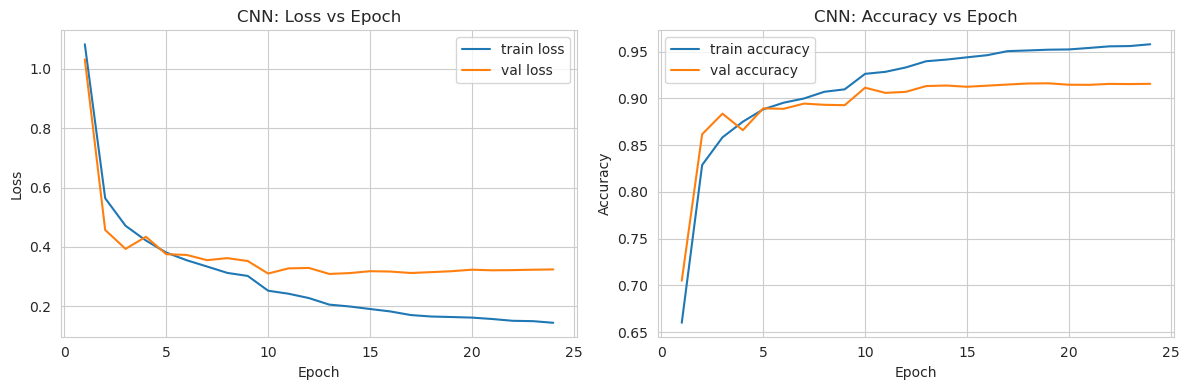

[CNN] Test loss:     0.3393
[CNN] Test accuracy: 0.9106


In [20]:
# 1) Build and compile CNN
cnn_model = build_cnn_model(
    input_shape=x_tr.shape[1:],  # (32,32,1)
    num_classes=10,
    conv_filters=(16, 32, 64),
    dense_units=64,
    dropout_rate=0.5,
)
compile_cnn_model(cnn_model, learning_rate=1e-3)

# Show model summary to verify param count and structure
cnn_model.summary()

# 2) Callbacks
cnn_callbacks = get_cnn_callbacks(
    base_dir="svhn_cnn_checkpoints",
    monitor="val_accuracy",
    patience=5,
)

# 3) Train (max 30 epochs as recommended)
history_cnn = train_cnn_model(
    cnn_model,
    x_tr,
    y_tr,
    x_val,
    y_val,
    epochs=30,
    batch_size=128,
    callbacks_list=cnn_callbacks,
)

# 4) Plot learning curves (loss + accuracy for train/val)
plot_cnn_learning_curves(history_cnn)

# 5) Evaluate on test set
cnn_test_loss, cnn_test_acc = evaluate_cnn_on_test(cnn_model, x_te, y_te)

# 6) (Optional) Compare with your MLP
# compare_model_params(mlp_model, cnn_model)


# 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [21]:
def load_best_mlp_and_cnn(
    mlp_checkpoint_path="svhn_mlp_checkpoints/best_mlp_checkpoint.keras",
    cnn_checkpoint_path="svhn_cnn_checkpoints/best_cnn_checkpoint.keras",
):
    """
    Load the best saved MLP and CNN models from disk.

    Assumes you saved full models (not only weights) using ModelCheckpoint.
    """
    mlp_model = load_model(mlp_checkpoint_path)
    cnn_model = load_model(cnn_checkpoint_path)

    print("Loaded MLP from:", mlp_checkpoint_path)
    print("Loaded CNN from:", cnn_checkpoint_path)

    return mlp_model, cnn_model


In [22]:
def select_random_test_samples(x_test, y_test, num_samples=5, seed=None):
    """
    Randomly select num_samples images and labels from test set.
    Returns (x_sel, y_sel, idx_sel).
    """
    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    N = x_test.shape[0]
    num_samples = min(num_samples, N)
    idx_sel = rng.choice(N, size=num_samples, replace=False)

    x_sel = x_test[idx_sel]
    y_sel = y_test[idx_sel]

    return x_sel, y_sel, idx_sel


In [23]:
def plot_predictions_for_samples(
    mlp_model,
    cnn_model,
    x_samples,
    y_samples,
    class_names=None,
):
    """
    For each sample:
      - show the image with true label
      - show MLP predictive distribution as bar chart + argmax prediction
      - show CNN predictive distribution as bar chart + argmax prediction

    Layout: rows = num_samples, columns = 3 (Image, MLP, CNN).
    """
    num_samples = x_samples.shape[0]

    # Predict probabilities
    mlp_probs = mlp_model.predict(x_samples, verbose=0)  # (N, 10)
    cnn_probs = cnn_model.predict(x_samples, verbose=0)  # (N, 10)

    mlp_pred = np.argmax(mlp_probs, axis=1)
    cnn_pred = np.argmax(cnn_probs, axis=1)

    # Class names 0..9 if none provided
    if class_names is None:
        class_names = [str(i) for i in range(10)]

    plt.figure(figsize=(12, 3 * num_samples))
    plt.suptitle("MLP vs CNN predictions on random test samples", fontsize=14)

    for i in range(num_samples):
        img = x_samples[i]
        true_label = y_samples[i]

        # Column 1: image + true label
        ax_img = plt.subplot(num_samples, 3, 3 * i + 1)
        if img.shape[-1] == 1:
            ax_img.imshow(img.squeeze(-1), cmap="gray")
        else:
            ax_img.imshow(img)

        ax_img.set_title(f"True: {true_label}", fontsize=10)
        ax_img.axis("off")

        # Column 2: MLP predictive distribution
        ax_mlp = plt.subplot(num_samples, 3, 3 * i + 2)
        ax_mlp.bar(range(10), mlp_probs[i])
        ax_mlp.set_xticks(range(10))
        ax_mlp.set_xticklabels(class_names)
        ax_mlp.set_ylim(0, 1.0)
        ax_mlp.set_ylabel("Prob.")
        ax_mlp.set_title(f"MLP pred: {mlp_pred[i]}", fontsize=10)
        ax_mlp.grid(True, axis="y", linestyle="--", alpha=0.3)

        # Column 3: CNN predictive distribution
        ax_cnn = plt.subplot(num_samples, 3, 3 * i + 3)
        ax_cnn.bar(range(10), cnn_probs[i])
        ax_cnn.set_xticks(range(10))
        ax_cnn.set_xticklabels(class_names)
        ax_cnn.set_ylim(0, 1.0)
        ax_cnn.set_ylabel("Prob.")
        ax_cnn.set_title(f"CNN pred: {cnn_pred[i]}", fontsize=10)
        ax_cnn.grid(True, axis="y", linestyle="--", alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [24]:
def show_random_test_predictions(
    x_test,
    y_test,
    mlp_checkpoint_path="svhn_mlp_checkpoints/best_mlp_checkpoint.keras",
    cnn_checkpoint_path="svhn_cnn_checkpoints/best_cnn_checkpoint.keras",
    num_samples=5,
    seed=42,
):
    """
    Full pipeline for step 4:

    1) Load best MLP and CNN from checkpoints.
    2) Randomly select num_samples test images.
    3) Plot each image + predictive distributions and argmax predictions.
    """
    # 1) Load models
    mlp_model, cnn_model = load_best_mlp_and_cnn(
        mlp_checkpoint_path=mlp_checkpoint_path,
        cnn_checkpoint_path=cnn_checkpoint_path,
    )

    # 2) Random sample from test set
    x_sel, y_sel, idx_sel = select_random_test_samples(
        x_test,
        y_test,
        num_samples=num_samples,
        seed=seed,
    )
    print("Selected test indices:", idx_sel)

    # 3) Show images + predictive distributions
    plot_predictions_for_samples(
        mlp_model=mlp_model,
        cnn_model=cnn_model,
        x_samples=x_sel,
        y_samples=y_sel,
        class_names=[str(i) for i in range(10)],
    )


Loaded MLP from: svhn_mlp_checkpoints/best_mlp_checkpoint.keras
Loaded CNN from: svhn_cnn_checkpoints/best_cnn_checkpoint.keras
Selected test indices: [ 1401 15434   401 23665 17760]


2025-11-29 04:30:14.362941: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19', 64 bytes spill stores, 64 bytes spill loads



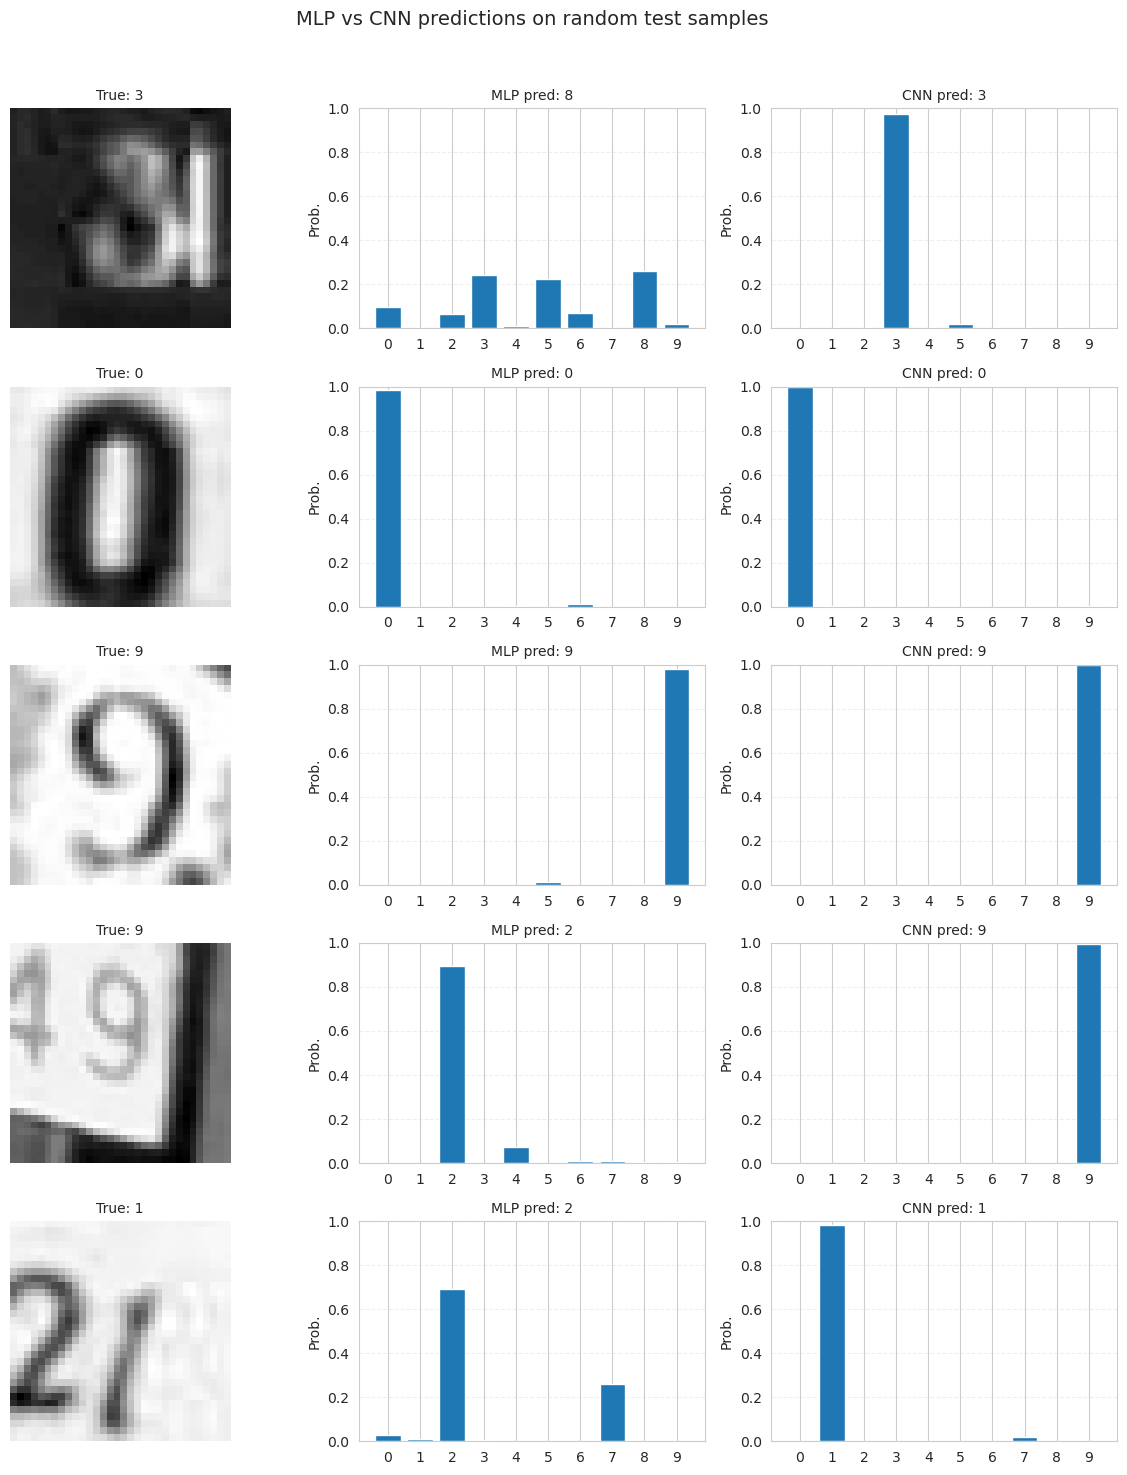

In [25]:

show_random_test_predictions(
    x_test=x_te,
    y_test=y_te,
    mlp_checkpoint_path="svhn_mlp_checkpoints/best_mlp_checkpoint.keras",
    cnn_checkpoint_path="svhn_cnn_checkpoints/best_cnn_checkpoint.keras",
    num_samples=5,
    seed=123,  # optional
)